In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

In [4]:


img_numbers = []
density_collect = []
integrated_movements = []
max_rs = []
number_waves = []
area_sums = []

for image in tqdm(list(images_folder.glob('[!.]*.tif'))):
    
    image_num = image.stem
    
    if image_num[0] == '.':
        continue

    wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
    arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
    tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))

    #So track IDs and corrresponding tracks are found in tracking df, 
    #The corresponding points that made the circle are in arcos df, 
    #the waves to analze are in waves df, need to go from 
    #WaveDF --> arcosDF --> trackingDF 
    #Get centroid and radius over time from waveDF, 
    #Get trackID inside wavefront from arcosDF, 
    #Get track from tracking, then calc radial movement as enter wavefront? 

    #Calc a stable centroid: 
    #Only looking at clID that hvae waves mapped to them for now...

    clIDs = wave_df.clTrackID.values

    wave_ex = wave_df[wave_df.clTrackID == clIDs[0]]
    arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[0]]

    centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
    mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

    #Get all tracking for all timepoints after a wave event has begun: 
    all_tracks_post_initiation = tracking_df[tracking_df['timepoint'] > arcos_df['timepoint'].min()]
    print('There are {} tracks post wave initiation...'.format(str(len(all_tracks_post_initiation.track_id.unique()))))

    arcos_whole_duration_track_collect = []
    min_track_duration = 36 #3min

    for tid, track in all_tracks_post_initiation.groupby('track_id'):
        if len(track) > min_track_duration:
            #Get the time, x, and y points, but DO NOT SMOOTH here. 
            #Smoothing for this aligned measurement brings forward the movement in time 
            #This confuses what we are getting at here, so do not smooth in time.
            time = track.timepoint.values*5.0

            #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
            coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
            lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
            radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
            dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
            inst_radial_step = [dist_from_center[i+1] - dist_from_center[i] for i in range(len(dist_from_center)-1)]
            velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
            angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
            cis = np.cos(angles)
            radial_velocity = velocity*cis

            #Integrate calcium signal over mean?
            int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

            #Append the relevant parameters to the track: 
            track['radial_dist'] = dist_from_center
            track['inst_radial_movement'] = np.insert(inst_radial_step, 0, float('nan'), axis=0)
            track['max_radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
            track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
            track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
            track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
            arcos_whole_duration_track_collect.append(track)

    arcos_duration_tracks_DF = pd.concat(arcos_whole_duration_track_collect, ignore_index=True)

    wave_start_times = []

    for wid, wave_event in wave_df.groupby('clTrackID'):
        wave_start_times.append(wave_event.timepoint.min())

    radial_movement_integration = 0.0

    coll_timepoints = []
    radial_collection = []

    for t, time_slice in arcos_duration_tracks_DF.groupby('timepoint'):
        radial_movement_integration -= np.nansum(time_slice.inst_radial_movement.values)
        coll_timepoints.append((5.0/60.0)*(t - min(wave_start_times)))
        radial_collection.append(radial_movement_integration)

    #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:

    event_sizes = []
    event_start_stops = []
    event_areas = []

    for clID, clEvent in wave_df.groupby('clTrackID'):

        event_start_stops.append((np.min(clEvent.timepoint.values), np.max(clEvent.timepoint.values)))
        event_areas.append(np.pi*(clEvent.circle_radius.max()**2))
        event_sizes.append(clEvent.circle_radius.max())
        
    #collect all the loop information and move to next file... 
    img_numbers.append(int(image_num))
    density_collect.append(arcos_df.cell_density[0])
    integrated_movements.append(radial_collection[-1])
    max_rs.append(max(event_sizes))
    number_waves.append(len(event_sizes))
    area_sums.append(sum(event_areas))

  0%|                                                                                                                                                                                | 0/57 [00:00<?, ?it/s]

There are 17440 tracks post wave initiation...


  2%|██▉                                                                                                                                                                   | 1/57 [01:08<1:03:42, 68.26s/it]

There are 31227 tracks post wave initiation...


  4%|█████▊                                                                                                                                                               | 2/57 [03:15<1:34:13, 102.79s/it]

There are 9098 tracks post wave initiation...


  5%|████████▋                                                                                                                                                             | 3/57 [04:07<1:11:45, 79.74s/it]

There are 5903 tracks post wave initiation...


  7%|███████████▊                                                                                                                                                            | 4/57 [04:31<50:53, 57.62s/it]

There are 34792 tracks post wave initiation...


  9%|██████████████▌                                                                                                                                                       | 5/57 [06:27<1:08:15, 78.77s/it]

There are 14636 tracks post wave initiation...


 11%|█████████████████▋                                                                                                                                                      | 6/57 [07:11<56:57, 67.01s/it]

There are 14578 tracks post wave initiation...


 12%|████████████████████▋                                                                                                                                                   | 7/57 [08:14<54:39, 65.59s/it]

There are 32464 tracks post wave initiation...


 14%|███████████████████████▎                                                                                                                                              | 8/57 [10:47<1:16:17, 93.41s/it]

There are 10137 tracks post wave initiation...


 16%|██████████████████████████▏                                                                                                                                           | 9/57 [11:42<1:05:10, 81.48s/it]

There are 11022 tracks post wave initiation...


 18%|█████████████████████████████▎                                                                                                                                         | 10/57 [12:48<59:58, 76.56s/it]

There are 19996 tracks post wave initiation...


 19%|███████████████████████████████▊                                                                                                                                     | 11/57 [14:19<1:02:13, 81.17s/it]

There are 32604 tracks post wave initiation...


 21%|██████████████████████████████████▋                                                                                                                                  | 12/57 [16:36<1:13:31, 98.03s/it]

There are 17307 tracks post wave initiation...


 23%|█████████████████████████████████████▋                                                                                                                               | 13/57 [17:34<1:03:01, 85.93s/it]

There are 15316 tracks post wave initiation...


 25%|█████████████████████████████████████████                                                                                                                              | 14/57 [18:42<57:45, 80.59s/it]

There are 19762 tracks post wave initiation...


 26%|███████████████████████████████████████████▉                                                                                                                           | 15/57 [20:00<55:55, 79.90s/it]

There are 26980 tracks post wave initiation...


 28%|██████████████████████████████████████████████▉                                                                                                                        | 16/57 [21:21<54:41, 80.04s/it]

There are 18495 tracks post wave initiation...


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 17/57 [22:53<55:45, 83.65s/it]

There are 20866 tracks post wave initiation...


 32%|████████████████████████████████████████████████████                                                                                                                 | 18/57 [25:05<1:03:49, 98.19s/it]

There are 23472 tracks post wave initiation...


 33%|███████████████████████████████████████████████████████                                                                                                              | 19/57 [26:42<1:02:02, 97.95s/it]

There are 10094 tracks post wave initiation...


 35%|██████████████████████████████████████████████████████████▌                                                                                                            | 20/57 [27:41<53:12, 86.27s/it]

There are 24854 tracks post wave initiation...


 37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 21/57 [29:35<56:37, 94.37s/it]

There are 22017 tracks post wave initiation...


 39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 22/57 [30:59<53:19, 91.43s/it]

There are 7891 tracks post wave initiation...


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                   | 23/57 [31:38<42:48, 75.56s/it]

There are 6764 tracks post wave initiation...


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                | 24/57 [32:38<39:06, 71.10s/it]

There are 15378 tracks post wave initiation...


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                             | 25/57 [34:19<42:37, 79.92s/it]

There are 35039 tracks post wave initiation...


 46%|██████████████████████████████████████████████████████████████████████████▊                                                                                         | 26/57 [37:54<1:02:15, 120.48s/it]

There are 18639 tracks post wave initiation...


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 27/57 [39:14<54:11, 108.37s/it]

There are 18629 tracks post wave initiation...


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 28/57 [40:38<48:45, 100.88s/it]

There are 19249 tracks post wave initiation...


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 29/57 [41:56<43:53, 94.05s/it]

There are 23336 tracks post wave initiation...


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 30/57 [44:11<47:51, 106.35s/it]

There are 27752 tracks post wave initiation...


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 31/57 [47:02<54:32, 125.85s/it]

There are 13917 tracks post wave initiation...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 32/57 [49:12<53:00, 127.22s/it]

There are 17580 tracks post wave initiation...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 33/57 [51:17<50:34, 126.42s/it]

There are 21825 tracks post wave initiation...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 34/57 [52:43<43:49, 114.31s/it]

There are 14627 tracks post wave initiation...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 35/57 [53:36<35:09, 95.90s/it]

There are 22857 tracks post wave initiation...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 36/57 [54:56<31:52, 91.07s/it]

There are 21928 tracks post wave initiation...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 37/57 [57:31<36:47, 110.38s/it]

There are 4009 tracks post wave initiation...


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 38/57 [58:00<27:13, 85.99s/it]

There are 43923 tracks post wave initiation...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 39/57 [1:01:14<35:31, 118.42s/it]

There are 4946 tracks post wave initiation...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 40/57 [1:01:53<26:48, 94.60s/it]

There are 39034 tracks post wave initiation...


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 41/57 [1:04:21<29:29, 110.62s/it]

There are 25807 tracks post wave initiation...


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 42/57 [1:07:18<32:35, 130.39s/it]

There are 5235 tracks post wave initiation...


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 43/57 [1:07:56<23:57, 102.67s/it]

There are 6409 tracks post wave initiation...


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 44/57 [1:08:37<18:15, 84.27s/it]

There are 36065 tracks post wave initiation...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 45/57 [1:10:50<19:46, 98.85s/it]

There are 27144 tracks post wave initiation...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 46/57 [1:13:15<20:39, 112.68s/it]

There are 34848 tracks post wave initiation...


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 47/57 [1:15:00<18:22, 110.24s/it]

There are 15327 tracks post wave initiation...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 48/57 [1:15:48<13:44, 91.63s/it]

There are 42478 tracks post wave initiation...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 49/57 [1:18:51<15:53, 119.17s/it]

There are 5419 tracks post wave initiation...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 50/57 [1:19:43<11:32, 98.88s/it]

There are 9245 tracks post wave initiation...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 51/57 [1:20:34<08:26, 84.43s/it]

There are 8821 tracks post wave initiation...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 52/57 [1:21:31<06:21, 76.28s/it]

There are 9519 tracks post wave initiation...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 53/57 [1:22:36<04:51, 72.96s/it]

There are 10611 tracks post wave initiation...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 54/57 [1:23:31<03:22, 67.64s/it]

There are 14166 tracks post wave initiation...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 55/57 [1:24:35<02:12, 66.44s/it]

There are 23035 tracks post wave initiation...


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 56/57 [1:26:14<01:16, 76.08s/it]

There are 9063 tracks post wave initiation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [1:26:51<00:00, 91.43s/it]


In [5]:

big_df = pd.DataFrame({'img_num':img_numbers,'density':density_collect,'integrated_move':integrated_movements,'max_r':max_rs,'num_waves':number_waves,'max_areas':area_sums})

big_df.to_csv('supp-fig4-max-wave-area-v-all-movement.csv')

In [6]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

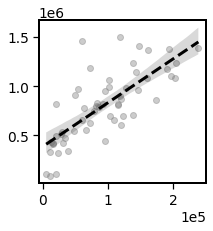

In [7]:
plt.figure(figsize=(3,3))
sns.regplot(data=big_df, y='max_areas', x='integrated_move', scatter_kws={'alpha':0.4, 'color':'grey'}, line_kws={'color':'black', 'linestyle':'--'})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('')
plt.ylabel('')
plt.savefig('fig4-supplement-max-wave-area-v-all-movement.png', dpi=300, bbox_inches='tight')

In [8]:
fit_ys_4c = big_df.dropna(axis=0)['max_areas'].values

fit_xs_4c = big_df.dropna(axis=0)['integrated_move'].values
fit_xs_4c = sm.add_constant(fit_xs_4c)
model_4c = sm.OLS(fit_ys_4c,fit_xs_4c)
results_4c = model_4c.fit()
print(results_4c.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     71.31
Date:                Tue, 02 May 2023   Prob (F-statistic):           1.65e-11
Time:                        12:44:31   Log-Likelihood:                -785.06
No. Observations:                  57   AIC:                             1574.
Df Residuals:                      55   BIC:                             1578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.86e+05    5.8e+04      6.656      0.0